# Rock Paper Scissors Image Classification - Final Submission Dicoding Indonesia
### Course : Belajar Machine Learning Pemula
**Date** : 24 April 2021

**Note** : Use Google Colab GPU Accelerator

**Nama** : Prinanda Rahmatullah

**Email** : prinanda50@gmail.com

In [1]:
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5746875116130679409
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14674281152
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11807587227649408368
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# import dependencies
import os
import sys
import time
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Softmax, Flatten, Activation, BatchNormalization
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator

In [4]:
os.environ["GPU_VISIBLE_DEVICE"] = "0"

## Define Needed Function

In [5]:
# transform image into array
def preprocess_image(image_path):
    img = load_img(image_path)
    img = img_to_array(img)
    img = img/255
    return img


# transform single image into array for prediction
def single_preprocess_image(image_path):
    img = load_img(image_path)
    img = img_to_array(img)
    img = img/255
    img = np.expand_dims(img, axis=0)
    return img

In [6]:
# read dan preprocess data
def prepare_data(data_path, class_directory):
    image_data = []
    label_data = []

    list_data = [sub for sub in list(os.listdir(data_path)) if sub in class_directory]
    label_size = len(list_data)

    # load image from each subject
    sub_num = 0
    for sub in (sorted(list_data)):
        for photo in tqdm(os.listdir(f"{data_path}/{sub}"), desc=f"{sub}"):
            if photo.endswith(".png"):
                filename = f"{data_path}/{sub}/{photo}"
                image_out = preprocess_image(filename)

                # iamge feature and class in binary
                image_data.append(image_out)
                label_data.append(sub)
        if(sub_num == 0):
            np_image = np.array(image_data)
        else:
            np_image = np.concatenate((np_image, np.array(image_data)))
        image_data.clear()
        sub_num += 1

    # encode train label
    label_encoder = LabelEncoder()
    label_data = label_encoder.fit_transform(label_data)
    label_data = to_categorical(label_data, label_size)

    # split data
    X = np_image
    y = label_data

    return (X, y, label_encoder)

In [7]:
# Initiate Constant
BS = 20
EPOCHS = 30
MODEL_NAME = "PRINCE"
LEARNING_RATE = 0.001

print("[INFO] Hyperparameter:")
print("Epoch\t\t: " + str(EPOCHS))
print("Learning rate\t: " + str(LEARNING_RATE))
print("Batch Size\t: " + str(BS))

[INFO] Hyperparameter:
Epoch		: 30
Learning rate	: 0.001
Batch Size	: 20


In [8]:
# Directory of dataset
data_path = f"/content/drive/MyDrive/Colab Notebooks/dicoding/data/rockpaperscissors/"
class_directory = ["paper", "rock", "scissors"]

list_data = [sub for sub in list(os.listdir(data_path)) if sub in class_directory]
label_size = len(list_data)

In [9]:
# READ DATA
X, y, label_encoder = prepare_data(data_path, class_directory)

scissors: 100%|██████████| 757/757 [00:02<00:00, 316.79it/s]


In [10]:
#SPLIT DATA
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [11]:
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(1317, 200, 300, 3) (878, 200, 300, 3)
(1317, 3) (878, 3)


## Build and Train Model

In [12]:
tf.keras.backend.clear_session()

In [13]:
# # DEFINE MODEL
model = Sequential()
model.add(Convolution2D(16, (3, 3), activation='relu', input_shape=(200, 300, 3)))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))
model.add(Convolution2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

model.add(Flatten())
model.add(Dense(32, activation="relu"))

# Channel sebanyak jumlah kelas
model.add(Dense(label_size, activation='softmax'))

# # Available to use benchmark architecture, but wasting it's performance only for 3 class
# model = ResNet50(classes=label_size, input_shape=X_train.shape[1:], weights=None)

# SUMMARY MODEL
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 198, 298, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 99, 149, 16)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 97, 147, 32)       4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 73, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 71, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 23, 35, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 21, 33, 128)       7

In [14]:
# COMPILE MODEL
adam = Adam(learning_rate=LEARNING_RATE)
# sgd = SGD(learning_rate=LEARNING_RATE)
model.compile(optimizer=adam, loss='categorical_crossentropy',
              metrics=['accuracy'])

In [15]:
# Initiate Callbacks
model_callbacks = [
        # EarlyStopping(monitor="val_loss", patience=5),
        CSVLogger(
            filename=f"/content/drive/MyDrive/Colab Notebooks/dicoding/log/history_{MODEL_NAME}_label{label_size}_e{EPOCHS}_bs{BS}.csv", separator=",", append=False),
        ModelCheckpoint(
            filepath=f"/content/drive/MyDrive/Colab Notebooks/dicoding/log/model_{MODEL_NAME}_label{label_size}_e{EPOCHS}_bs{BS}_val_loss.h5", monitor="val_loss", save_best_only=True),
        ModelCheckpoint(
            filepath=f"/content/drive/MyDrive/Colab Notebooks/dicoding/log/model_{MODEL_NAME}_label{label_size}_e{EPOCHS}_bs{BS}_val_accuracy.h5", monitor="val_accuracy", save_best_only=True)
    ]

In [16]:
# construct the image generator for data augmentation
aug = ImageDataGenerator(rotation_range=30, width_shift_range=0.1,
                         height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
                         horizontal_flip=True, fill_mode="nearest")

In [17]:
# Initiate start time
start_time = time.time()

# TRAIN MODEL
Historia = model.fit(
    aug.flow(X_train, y_train, batch_size=BS),
    validation_data=(X_test, y_test),
    callbacks=model_callbacks,
    epochs=EPOCHS,
    batch_size=BS)

# end time
print("\n\n--- %s seconds ---" % (time.time() - start_time))

Epoch 1/30
66/66 [==============================] - 19s 249ms/step - loss: 1.0585 - accuracy: 0.4251 - val_loss: 0.5400 - val_accuracy: 0.7779
Epoch 2/30
66/66 [==============================] - 16s 238ms/step - loss: 0.5508 - accuracy: 0.7793 - val_loss: 0.2426 - val_accuracy: 0.9339
Epoch 3/30
66/66 [==============================] - 16s 239ms/step - loss: 0.3476 - accuracy: 0.8862 - val_loss: 0.1953 - val_accuracy: 0.9339
Epoch 4/30
66/66 [==============================] - 16s 241ms/step - loss: 0.3924 - accuracy: 0.8545 - val_loss: 0.1829 - val_accuracy: 0.9408
Epoch 5/30
66/66 [==============================] - 16s 239ms/step - loss: 0.3052 - accuracy: 0.8832 - val_loss: 0.1668 - val_accuracy: 0.9487
Epoch 6/30
66/66 [==============================] - 16s 239ms/step - loss: 0.3324 - accuracy: 0.8805 - val_loss: 0.1643 - val_accuracy: 0.9453
Epoch 7/30
66/66 [==============================] - 16s 239ms/step - loss: 0.2883 - accuracy: 0.9017 - val_loss: 0.1296 - val_accuracy: 0.9544

## Evaluate Model

In [18]:
# EVALUATE MODEL BASED ON LOSS
model = load_model(f"/content/drive/MyDrive/Colab Notebooks/dicoding/log/model_{MODEL_NAME}_label{label_size}_e{EPOCHS}_bs{BS}_val_loss.h5")

loss, acc = model.evaluate(X_train, y_train, batch_size=BS)
print("Training Loss\t\t: ",loss)
print("Training Accuracy\t: ", acc)
print("\n")
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=BS)
print("Validation Loss\t\t: ", val_loss)
print("Validation Accuracy\t: ", val_acc)

66/66 [==============================] - 1s 11ms/step - loss: 0.0188 - accuracy: 0.9932
Training Loss		:  0.01879359968006611
Training Accuracy	:  0.9931662678718567


44/44 [==============================] - 1s 11ms/step - loss: 0.0354 - accuracy: 0.9897
Validation Loss		:  0.03535572066903114
Validation Accuracy	:  0.9897494316101074


In [19]:
# EVALUATE MODEL BASED ON ACCURACY
model = load_model(f"/content/drive/MyDrive/Colab Notebooks/dicoding/log/model_{MODEL_NAME}_label{label_size}_e{EPOCHS}_bs{BS}_val_accuracy.h5")

loss, acc = model.evaluate(X_train, y_train, batch_size=BS)
print("Training Loss\t\t: ",loss)
print("Training Accuracy\t: ", acc)
print("\n")
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=BS)
print("Validation Loss\t\t: ", val_loss)
print("Validation Accuracy\t: ", val_acc)

66/66 [==============================] - 1s 11ms/step - loss: 0.0188 - accuracy: 0.9932
Training Loss		:  0.01879359968006611
Training Accuracy	:  0.9931662678718567


44/44 [==============================] - 0s 11ms/step - loss: 0.0354 - accuracy: 0.9897
Validation Loss		:  0.03535572066903114
Validation Accuracy	:  0.9897494316101074


In [20]:
# model prediction for testing data
predictions = [np.argmax(x) for x in model.predict(X_test, batch_size=BS)]
tes = [np.argmax(y) for y in y_test]

In [21]:
# Print classification report
target_names = label_encoder.classes_
report = classification_report(tes, predictions, target_names=target_names, output_dict=True)
dataframe = pd.DataFrame(report).transpose()
dataframe.to_csv(f"/content/drive/MyDrive/Colab Notebooks/dicoding/log/reports_{MODEL_NAME}_label{label_size}_e{EPOCHS}_bs{BS}.csv")
print(classification_report(tes, predictions, target_names=target_names))

              precision    recall  f1-score   support

       paper       0.99      0.98      0.98       294
        rock       0.99      1.00      0.99       282
    scissors       0.99      0.99      0.99       302

    accuracy                           0.99       878
   macro avg       0.99      0.99      0.99       878
weighted avg       0.99      0.99      0.99       878



In [22]:
# print confusion matrix
confusion_mtx = confusion_matrix(tes, predictions)
print(confusion_mtx)

[[288   2   4]
 [  1 281   0]
 [  2   0 300]]


## Observe Model Performance using Visualization

In [23]:
# xlimit
Numero = np.arange(1, EPOCHS+1, 1)

In [24]:
# Font option
title_font = {'weight': 'medium', 'size': 'medium'}
axis_font = {'size': 'small'}

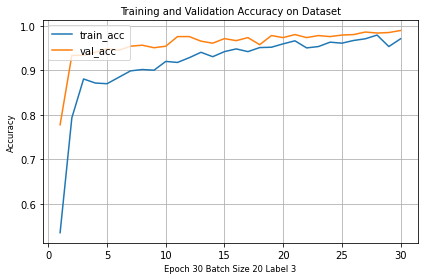

In [25]:
# ACCURACY

# plot accuracy
plt.figure()
plt.plot(Numero, Historia.history["accuracy"], label="train_acc")
plt.plot(Numero, Historia.history["val_accuracy"], label="val_acc")
plt.title("Training and Validation Accuracy on Dataset", **title_font)
plt.xlabel(
    f"Epoch {EPOCHS} Batch Size {BS} Label {label_size}", **axis_font)
plt.ylabel("Accuracy", **axis_font)
plt.legend(loc='upper left')
plt.tight_layout()
plt.grid()
plt.savefig(
    f"/content/drive/MyDrive/Colab Notebooks/dicoding/log/figure_accuracy_{MODEL_NAME}_label{label_size}_e{EPOCHS}_bs{BS}.png", dpi=600)

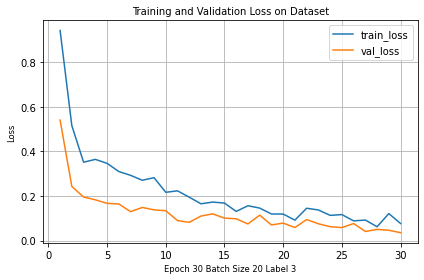

In [27]:
# LOSS

# plot loss
plt.figure()
plt.plot(Numero, Historia.history["loss"], label="train_loss")
plt.plot(Numero, Historia.history["val_loss"], label="val_loss")
plt.title("Training and Validation Loss on Dataset", **title_font)
plt.xlabel(
    f"Epoch {EPOCHS} Batch Size {BS} Label {label_size}", **axis_font)
plt.ylabel("Loss", **axis_font)
plt.legend(loc='upper right')
plt.tight_layout()
plt.grid()
plt.savefig(
    f"/content/drive/MyDrive/Colab Notebooks/dicoding/log/figure_loss_{MODEL_NAME}_label{label_size}_e{EPOCHS}_bs{BS}.png", dpi=600)

## Predict from Uploaded Image (MAX : 5 IMAGE)

In [28]:
from google.colab import files
uploaded = files.upload()

Saving 0a3UtNzl5Ll3sq8K.png to 0a3UtNzl5Ll3sq8K.png
Saving 0OEXfEooCXlljaEl.png to 0OEXfEooCXlljaEl.png
Saving 0Ug54ifXRqqlZS2Z.png to 0Ug54ifXRqqlZS2Z.png


In [29]:
# Preprocess uploaded image
uploaded_image = np.array([preprocess_image(x) for x in uploaded.keys()])
uploaded_image.shape

(3, 200, 300, 3)

In [30]:
# get label predictions
output_predictions = [label_encoder.classes_[np.argmax(label)] for label in model.predict(uploaded_image)]
output_predictions

['paper', 'rock', 'scissors']

RESULT	:


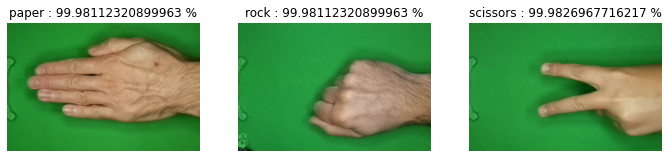

In [31]:
print("RESULT\t:")
# plot uploaded image with label
fig = plt.figure(figsize=(20,15))
count = 1
for image in uploaded_image:
  ax = fig.add_subplot(1, 5, count)
  imgplot = plt.imshow(image)
  ax.set_title(f"{output_predictions[count-1]} : {(np.amax(model.predict(uploaded_image[:count]))*100)} %")
  ax.axis('off')
  count += 1
plt.show()